In [1]:
pip install biopython

  Using cached biopython-1.84-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
Using cached biopython-1.84-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install venny4py

  Using cached venny4py-1.0.3-py3-none-any.whl.metadata (1.8 kB)
Using cached venny4py-1.0.3-py3-none-any.whl (4.5 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import Align
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import re
import os
import copy
import pickle
import seaborn as sns
import gzip
import math
from venny4py.venny4py import *
import matplotlib.pyplot as plt
import datetime
from itertools import combinations
date = datetime.datetime.now().strftime("%Y-%m-%d")
#from colorspacious import cspace_converter
#for statistics
import statistics
from scipy.stats import ttest_ind
from scipy.stats import chisquare
from scipy.stats import binomtest
from scipy.stats import ttest_rel
from scipy.stats import chi2_contingency, ttest_ind, levene, f, kruskal, chi2, linregress

In [4]:
def pickle_load(file):
    with gzip.open(file, 'rb') as f:
        print(f'file {file} loaded')
        gRNA_dict=pickle.load(f)
    return gRNA_dict    
#
#
def pickle_out(gRNA_dict,outfile):
    with gzip.open(outfile, 'wb') as f:
        pickle.dump(gRNA_dict, f)
    f.close()
#
#
def rename_strain(df):
    new=[]
    taxon_dict={'T.b. gambiense type I':'TbgI','T.b. gambiense type II':'TbgII',
                              'T.b. brucei':'Tbb','T.b. rhodesiense':'Tbr',
                             'T.b.':'Tb','T. brucei':'Tb'}
    for i,j in zip(df.index,df['taxon']):
        if j in taxon_dict:
            new.append(f'{taxon_dict[j]}_{i}')
        else:
            new.append(f'Tb_{i}')
    return(new)
#
def strain_mini(combined):
    strain_mini_sets={strain: [idx for idx in combined.loc[strain][~(combined.loc[strain].isna())].index if 'Tb_mO' in idx] for strain in combined.index}
    return(strain_mini_sets)
#
#assign mini families to each strain
def strain_mini_fam(strain_mini_sets,mini_family):
    def by_intersection(mfs1,mfs2,mini_family): 
        similarity1,similarity2={},{}
        for mf1 in mfs1:
            try:
                gfs1=set([g for g in mini_family[mf1]['cassettes'].split(';') if g != 'n'])
                s=max([len(gfs1.intersection(set([g for g in mini_family[mf2]['cassettes'].split(';') if g != 'n'])))/len(gfs1) for mf2 in mfs2 if mf2!='non_cannonical'])
                similarity1[mf1]=round(s,3)
                s=max([len(gfs1.intersection(set([g for g in mini_family[mf2]['cassettes'].split(';') if g != 'n']))) for mf2 in mfs2 if mf2 in mini_family if mf2!='non_cannonical'])
                similarity2[mf1]=s
            except:
                print([len(gfs1.intersection(set([g for g in mini_family[mf2]['cassettes'].split(';') if g != 'n'])))/len(gfs1) for mf2 in mfs2 if mf2!='non_cannonical'])
        return(similarity1,similarity2)
    def by_cassette_position(mfs1,mfs2,mini_family): #must be present at the same cassette position
        similarity1,similarity2={},{}
        for mf1 in [mf1 for mf1 in mfs1 if mf1 !='non_cannonical']: #mf1: all Tb mfs
            s=max([sum([1 for i,j in zip(mini_family[mf1]['cassettes'].split(';'),mini_family[mf2]['cassettes'].split(';')) if i==j and i!='n'])
                   /len([i for i in mini_family[mf1]['cassettes'].split(';') if i!='n']) #divided by the number of cannonical gRNAs in mf1
                   for mf2 in mfs2 if mf2 != 'non_cannonical']) #mf2: mf contained in a certain strain
            similarity1[mf1]=round(s,3)
        return(similarity1,similarity2)
    #
    class_family_dict={mini:fam for fam in mini_family for mini in mini_family[fam]['class']}
    mini_fam_sets={s:list(set([class_family_dict.get(mini,'non_cannonical') for mini in strain_mini_sets[s]])) for s in strain_mini_sets}
    mini_fam_sets={k: v for k, v in sorted(mini_fam_sets.items(), key=lambda item: item[0])}
    #sort mini by presence
    mf_presence,mf_similarity1,mf_similarity2={},{},{}
    for mf in mini_family:
        a=[1 for s in mini_fam_sets if mf in mini_fam_sets[s]]
        presence=sum(a)/len(mini_fam_sets)
        mf_presence[mf]=presence
    mf_presence={k: v for k, v in sorted(mf_presence.items(), key=lambda item: item[1],reverse = True)}
    #reorder mini families
    mini_family={k:mini_family[k] for k in mf_presence}
    #similarity
    for strain in mini_fam_sets:
        #similarity1,similarity2=by_intersection(mini_family,mini_fam_sets[strain],mini_family)
        similarity1,similarity2=by_cassette_position(mini_family,mini_fam_sets[strain],mini_family)
        mf_similarity1[strain]=similarity1
        mf_similarity2[strain]=similarity2
    return (mini_fam_sets,mf_presence,mini_family,mf_similarity1,mf_similarity2)

#remove those unique to SitaBip1: #something I checked on the server
def SitaBip1_remove(mf_presence,renamed_mini_family):
    print(f"Total minicircle family before remove those unique to SitaBip1:{len(renamed_mini_family)}")
    renamed_mini_family2={k:renamed_mini_family[k] for k in renamed_mini_family if mf_presence[k]!=0}
    print(f"Total minicircle family after remove those unique to SitaBip1: {len(renamed_mini_family2)}")
    return(renamed_mini_family2)

#
def plot_mfam_presence(mini_fam_sets,mini_family,out,figw=50,figh=100): #color by number of cannonical cassettes
    colors={5:'red',2:'cornflowerblue',3:'green',4:'orange',1:'black'}
    fig,ax = plt.subplots(1,1,figsize=(figw,figh))
    y=0
    for s in mini_fam_sets:
        presence=[i  for i,mf in enumerate(mini_family) if mf in mini_fam_sets[s]]
        cs=[colors[len([gf for gf in mini_family[mf]['cassettes'].split(';') if gf != 'n'])] for mf in mini_family if mf in mini_fam_sets[s]]
        ax.scatter(presence,[y]*len(presence),color=cs,marker='|')
        ax.text(-70,y,f"{s}")
        y+=1
    ax.set_xlim(-80,len(mini_family)+1)
    plt.savefig(out)
    plt.show()
#
#
def plot_mfam_similarity(mf_similarity1,mini_family,mini_fam_sets,out=False,figw=50,figh=100):
    colors={'TbgI':'red','TbgII':'cornflowerblue','Tbb':'green','Tbr':'orange','Tb':'black'}
    fig,ax = plt.subplots(1,1,figsize=(figw,figh))
    y=0
    for s in mf_similarity1:
        similarity=[mf_similarity1[s][k]**2 for k in mf_similarity1[s]]
        ax.scatter(range(len(similarity)),[y]*len(similarity),color='dimgray',marker='|',alpha=similarity)
        presence=[i  for i,mf in enumerate(mini_family) if mf in mini_fam_sets[s]]
        ax.scatter(presence,[y]*len(presence),color=colors[s.split('_')[0]],marker='|')
        ax.text(-70,y,f"{s}",color=colors[s.split('_')[0]])
        y+=1
    ax.set_xlim(-80,len(mini_family)+1)
    plt.savefig(out)
    plt.show()
#
#
def plot_mfam_number_of_gfam(mini_family,mf_presence,out=False,figw=20,figh=5):
    fig,ax = plt.subplots(1,1,figsize=(figw,figh))
    y=0
    cs=[len([gf for gf in mini_family[mf]['cassettes'].split(';') if gf != 'n']) for mf in mini_family]
    alphas=[mf_presence[mf] for mf in mini_family]
    ax.scatter(range(len(cs)),cs,color='blue',alpha=alphas)
    ax.plot(range(len(cs)),cs,color='grey',alpha=0.3)
    ax.set_xlim(-80,len(mini_family)+1)
    ax.set_ylabel('number of cassettes')
    #plt.savefig(out)
    plt.show()
#
#
def cumulation_plot_mf(mini_fam_sets,figw=20,figh=10):
    colors={'TbgI':'red','TbgII':'cornflowerblue','Tbb':'green','Tbr':'orange','Tb':'black'}
    pres=['TbgI_','Tbr_','Tbb_','TbgII_','Tb_']
    cumulate,sets,mf_counts,cs={k:{'set':[],'count':[],'colors':[]} for k in pres},[],[],[]
    for prefix in pres:#order by subspecies
        for strain in mini_fam_sets:
            if prefix in strain:
                cumulate[prefix]['set']+=mini_fam_sets[strain]
                sets+=mini_fam_sets[strain]
                cumulate[prefix]['set']=list(set(cumulate[prefix]['set']))
                sets=list(set(sets))
                cumulate[prefix]['count'].append(len(cumulate[prefix]['set']))
                mf_counts.append(len(sets))
                cumulate[prefix]['colors'].append(colors[prefix.replace('_','')])
                cs.append(colors[prefix.replace('_','')])
                
    #plot
    fig,axs = plt.subplots(2,1,figsize=(figw,figh))
    ax=axs[0]
    for k in cumulate:
        ax.scatter(range(len(cumulate[k]['count'])),cumulate[k]['count'],color=colors[k.replace('_','')],label=k.replace('_',''))
        ax.plot(range(len(cumulate[k]['count'])),cumulate[k]['count'],color=colors[k.replace('_','')])
    ax.set_ylabel('accumulative counts of total unique minicircle families')
    ax.set_xlabel('number of strains')
    ax.legend()
    ax=axs[1]
    ax.scatter(range(len(mf_counts)),mf_counts,color=cs)
    #plt.savefig(out)
    plt.show()
    #print(mf_count,cs)
    
#heatmap and dendrogram
def draw_heatmap_dendrogram(df,heatmapout,dendro_out):
    def similarity(s1,s2,df):
        l=max(len(df.loc[s1][df.loc[s1]==1]),len(df.loc[s2][df.loc[s2]==1])) #use the one with more cassettes as denominator
        a=round(sum((1-abs(np.array(df.loc[s1])-np.array(df.loc[s2]))).tolist())/l,3)
        return(a)
    diff_dict={s1:{s2:similarity(s1,s2,df) for s2 in df.index} for s1 in df.index}
    diff_mtx=pd.DataFrame.from_dict(diff_dict,orient='index')
    #heatmap
    fig, ax = plt.subplots(figsize=(150,150))
    ax=sns.heatmap(diff_mtx,square=True,ax=ax)
    plt.savefig(heatmapout)
    #dendrogram
    Z = linkage(diff_mtx, method='ward', metric='euclidean')
    fig = plt.figure(figsize=(25, 20))
    dn = dendrogram(Z,labels=diff_mtx.index)
    plt.savefig(dendro_out)
#
#
#change minicircle names
def rename_minicircles(mini_family,clean_mini_log):
    match_dict={list(filter(None,l.strip('\n').split(' ')))[0]:list(filter(None,l.strip('\n').split(' ')))[1] for l in open(clean_mini_log)}
    match_dict['Maxicircle']='Maxicircle'
    for mf in mini_family:
        mini_family[mf]['class']=[match_dict[m] for m in mini_family[mf]['class']]
    return(mini_family)
#
#
def make_fake_sequence(metadf,mini_fam_sets,mf_similarity1,outfile): #only need to include metadf, so combined is actually better, as the name has changed accordingly already
    surfix={'Central Africa':'CA','East Africa':'EA','na':'na','North Africa':'NA','Southern Africa':'SA','West Africa':'WA'}
    #metadf=metadf.apply(lambda x:, axis=1)
    seqs={s:''.join(['P' if mf in mini_fam_sets[s] else 'R' if mf_similarity1[s][mf]>=0.6 else '0' 
       for mf in mf_similarity1[s]]) 
       for s in mf_similarity1}
    #add continent as surfix for coloring
    records=[SeqRecord(Seq(seqs[s]),
            id=f"{s}_{surfix[metadf.loc[s,'continent']]}_{metadf.loc[s,'country'].replace(' ','_')}_{metadf.loc[s,'Year of isolation']}",
            description=s,name=s) for s in seqs]
    SeqIO.write(records,outfile,'fasta')
    return(records)
#
#modify the first step for data input
def process_df(csv,meta2):
    df=pd.read_csv(csv,index_col=0)#.rename(columns=df.iloc[0]).drop(df.index[0])
    df=df.drop(['MSUS-CI-78-TSW390','GUIWI-BOBO80-MURAZ18','SN54-TREU96']) #remove the known contaminated samples and Tbeq
    #clean up metadata
    metadf2=pd.read_csv(meta2,index_col=0,encoding='cp1252') #not utf8 encoding
    try:
        metadf2=metadf2.drop(['MSUS-CI-78-TSW390','GUIWI-BOBO80-MURAZ18','SitaBip1','SN54-TREU96','ABBA_b'])
    except:
        print('already removed')
    metadf2['taxon']=metadf2['taxon'].fillna('T. brucei').replace('T.b.','T. brucei')
    metadf2.rename(columns={'Year of isolation ': 'Year of isolation'}, inplace=True)
    metadf2['continent']=metadf2['continent'].fillna('na').replace('Southern Africa\xa0','Southern Africa')
    metadf2['country']=metadf2['country'].fillna('na')
    metadf2['Year of isolation']=metadf2['Year of isolation'].fillna('na')
    for s in ['MHOM-CI-78-DALOA72-cloneA','MHOM-CI-79-DALOA74','MHOM-CI-91-SIQUE1623','MHOM-ZR-71-C126','MSUS-CI-82-TSW125-KP1-cloneB']:
        metadf2.loc[s,'taxon']='T.b. gambiense type I'
    for s in ['MSUS-CI-78-TSW168']:
        metadf2.loc[s,'taxon']='T.b. gambiense type II'
    for s in ['MSUS-CI-78-TSW178','MSUS-CI-78-TSW38-021','MSUS-CI-78-TSW382-bis']:
        metadf2.loc[s,'taxon']='T.b. brucei'
    #Zambia is assigned to EA and SA --> assign all Zambia to SA
    for s in metadf2[metadf2.apply(lambda x:x['country']=='Zambia' and x['continent']=='East Africa', axis=1)].index:
        metadf2.loc[s,'continent']='Southern Africa'
    #ignore Tbeq Tbev data for now
    metadf2=metadf2.loc[metadf2.index.intersection(df.index)]
    #combine
    combined=pd.concat([df,metadf2], axis=1) #append won't change the order of columns (no auto sorting)
    renames=rename_strain(combined)
    combined['renamed']=renames
    combined=combined.set_index('renamed')
    return(metadf2,combined)

#in how many strains is each gf present
def gf_presence_func(gfam,gRNA_dict,combined):
    gf_presence={}
    for s in set(combined['taxon']):
        gf_presence[s]={}
        df=combined[combined['taxon']==s]
        for gf in gfam:
            total=[]
            for g in gfam[gf]['gRNA']:
                mini=gRNA_dict[g]['mO_name']
                try:
                    total+=list(df[df[mini].notnull()].index)
                except:
                    continue
            gf_presence[s][gf]=round(len(set(total))/len(df),6) #the ratio is used to color the patches for each gf
    return gf_presence
#deletion
def read_deletion_sites(deletion):
    deletion=SeqIO.to_dict(SeqIO.parse(deletion,'fasta'))
    delets={}
    for k in deletion:
        sites=[0 if b!='-' else 1 for b in deletion[k].seq] #0 for deletion sites
        delets[k]=sites
    return(delets)
# insertions
def read_editing_sites(small_u):
    smallu=SeqIO.to_dict(SeqIO.parse(small_u,'fasta'))
    edits={}
    for k in smallu:
        sites=[1 if b=='u' else 0 for b in smallu[k].seq] #1 for insertions
        edits[k]=sites
    return(edits)
#adjusted to alignment result of small u file
def adjust_deletions(small_u,deletion,outfile):
    insertions=SeqIO.to_dict(SeqIO.parse(small_u,'fasta'))
    dels=SeqIO.to_dict(SeqIO.parse(deletion,'fasta'))
    for k,v in insertions.items():
        add=0
        for i,b in enumerate(v.seq):
            if b=='-':
                position=len(v.seq[:i].replace('-',''))
                dels[k].seq=dels[k].seq[:position+add]+'-'+dels[k].seq[position+add:] #change '-' to 'a' for viewing adjustments
                add+=1
    records=[SeqRecord(v.seq,id=v.id,name=v.name,description=v.description) for k,v in dels.items()]
    SeqIO.write(records,outfile,'fasta')

In [5]:
#check copy number of a gene (gRNA family)
def gfam_copy_number(strain,strain_mini_sets,gRNA_by_mini,gfam,combined):
    gfam_copy={}
    canonical=[i for i in strain_mini_sets[strain] if i in gRNA_by_mini]
    for mini in canonical:
        tmpgf={v['gRNA_family'][0]:{v['gRNA']:combined.loc[strain,mini]} for v in gRNA_by_mini[mini]}
        for gf in tmpgf:
            if gf in gfam_copy:
                gfam_copy[gf].update(tmpgf[gf])
            else:
                gfam_copy[gf]=tmpgf[gf]
    size=sum([combined.loc[strain,i] for i in strain_mini_sets[strain]])
    #fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), sharey=True)
    #axs.hist(gfam_copy.values(),bins=range(0,round(max(gfam_copy.values())),8))
    #axs.set_xlabel(f"{strain}: {round(size)}, #gf: {len(gfam_copy)}")
    #plt.show()
    return (gfam_copy)
def gfam_copy_iter(strain_mini_sets,mini_dict2,gfam,combined):
    strain_gfam={}
    for strain in strain_mini_sets:
        strain_gfam[strain]=gfam_copy_number(strain,strain_mini_sets,mini_dict2,gfam,combined)
    return strain_gfam
#visualize gfam analysis
def t_test(col,subject,combined,value):
    for t in [i for i in set(combined[col]) if i != subject]:
        subj=combined[combined[col]==subject][value]
        query=combined[combined[col]==t][value]
        a=ttest_ind(subj, query)
        #if a.pvalue<0.05:
        print('pvalue',round(a.pvalue,4),f"{subject} mean: {round(sum(subj)/len(subj),2)} vs {t} mean {round(sum(query)/len(query),2)}")

In [6]:
def assign_gRNA_fam_to_mini(gRNA_dict,gRNA_families): #use the new version
    mini_dict,cassettes,non_cannonical={},['I','II','III','IV','V','Orphan'],[]
    for g in gRNA_dict:
        if  'Maxi' not in gRNA_dict[g]['mO_name']:
            if gRNA_dict[g]['mO_name'] not in mini_dict:
                mini_dict[gRNA_dict[g]['mO_name']]={c:set() for c in cassettes}
                mini_dict[gRNA_dict[g]['mO_name']][gRNA_dict[g]['cassette_label']].add(g)
            else:
                mini_dict[gRNA_dict[g]['mO_name']][gRNA_dict[g]['cassette_label']].add(g)
    mini_dict.pop('Maxicircle','None') #remove maxicircle      
    mini_df = pd.DataFrame(columns=cassettes,index=mini_dict.keys())
    for mini in mini_dict:
        for c in mini_dict[mini]:
            try:
                mini_df.loc[[mini],[c]]=mini_dict[mini][c]['gRNA_family'][0]
            except:
                non_cannonical.append(f"no cannonical gRNA found in cassette {c} in minicircle {mini}")
    mini_df=mini_df.sort_values(by=cassettes)
    tmp={k:sum([1 for cs in v.values() if cs==set()]) for k,v in mini_dict.items()}
    tmp={k: v for k, v in sorted(tmp.items(), key=lambda item: item[1])}
    ordered=list(tmp.keys())
    mini_dict={k:mini_dict[k] for k in ordered}
    return(mini_dict,mini_df)
#group minicircles by gRNA family
def make_minicircle_family(mini_dict,gRNA_dict):
    mini_families={}
    for mini in mini_dict:
        #put gRNA family to cassettes
        hit=0
        mini_casettes={c: set([i for g in v for i in gRNA_dict[g]['gRNA_family']]) for c,v in mini_dict[mini].items()}
        if mini_families=={}:
            count=1
            mini_families[f"mf{count}"]={'cassettes': mini_casettes,'population':[mini]}
        else:
            for mf,records in mini_families.items():
                test=[0 if set(i) == set(j) else 1 for i,j in zip(mini_casettes.values(),mini_families[mf]['cassettes'].values())]
                if sum(test)==0:
                    mini_families[mf]['population'].append(mini)
                    hit+=1
                    break
            if hit==0: #if no matches were found
                count+=1
                mini_families[f"mf{count}"]={'cassettes': mini_casettes,'population':[mini]}
    #print(mini_families.keys())
    #sort by the number of encoded gRNAs
    tmp={k:sum([1 for cs in v['cassettes'].values() if cs==set()]) for k,v in mini_families.items()}
    tmp={k: v for k, v in sorted(tmp.items(), key=lambda item: item[1])}
    ordered=list(tmp.keys())
    mini_families={k:mini_families[k] for k in ordered}
    print(len(mini_families))
    return(mini_families)

In [7]:
csv='/home/jovyan/Minicircle_gRNA_families/In_files/Tb_copy_number_norm2_maxi30.20240209.csv'
meta2='/home/jovyan/Minicircle_gRNA_families/In_files/all_annotated_metadata_isolates_2024-09-02.csv' #updated_metadata_isolates 2022-01-09.csv'

Tb_pickle_updated='/home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb/all_Tb_updated_4_dicts_0829.pickle'
merged_cassettes='/home/jovyan/Minicircle_gRNA_families/In_files/merged_cassettes_20240529.pickle'
#mRNA
small_u='/home/jovyan/Minicircle_gRNA_families/Compare_strains/Tbg1_small_u_aligned_with_Tb.fasta'
deletion='/home/jovyan/Minicircle_gRNA_families/Compare_strains/Mongo_deletions_mRNA_v1.txt'
aligned_del='/home/jovyan/Minicircle_gRNA_families/Compare_strains/Mongo_deletions_mRNA_v1_aligned_with_Tb.txt'
adjust_deletions(small_u,deletion,aligned_del)
#5 known Tbg1 strains in Tb are relabelled
metadf2,combined=process_df(csv,meta2)
#minor corrections of the taxon
taxon_correct={'T.b. gambiense type I':'T.b. gambiense type I','T.b. gambiense type II':'T.b. gambiense type II',
                              'T.b. brucei':'T.b. brucei','T.b. rhodesiense':'T.b. rhodesiense',
                             'T.b.':'T. brucei','T. brucei':'T. brucei'}
taxa=[taxon_correct.get(t,'T. brucei') for t in combined['taxon']]
combined['taxon']=taxa
mini_class=[len([i for i in combined.loc[s].dropna().index if 'Tb_mO' in i]) for s in combined.index]
combined['minicircle_classes']=mini_class
strain_mini_sets=strain_mini(combined)
combined['Total MCN per network']=[sum([combined.loc[strain,i] for i in strain_mini_sets[strain]]) for strain in combined.index]
#
cass_dict=pickle_load(merged_cassettes)
cass_dict={f"cass{i}":v for i,v in enumerate(cass_dict.values())}
cass_dict={f"{v['mO_name']}_{v['cassette_label']}":{k:int(value) if 'start' in k or 'end' in k else value for k,value in v.items()} for c,v in cass_dict.items()}
tmp=pickle_load(Tb_pickle_updated)
gRNA_dict,gRNA_families,mini_dict,renamed_mini_family=tmp[0],tmp[1],tmp[2],tmp[3]
gfam={gf:record for m,v in gRNA_families.items() for gf,record in v.items()}
for gf in gfam:
    rightmost=[int(gRNA_dict[g]['mRNA_end'])-6 for g in gfam[gf]['gRNA']]
    leftmost=[int(gRNA_dict[g]['mRNA_start']) for g in gfam[gf]['gRNA']]
cassettes=['I','II','III','IV','V','Orphan']
for gf in gfam:
    cs=[gRNA_dict[g]['cassette_label'] for g in gfam[gf]['gRNA']]
    gfam[gf]['cassettes']={c:cs.count(c) for c in cassettes} 
print(f"{len(gRNA_dict)} gRNAs and {len(mini_dict)} minicircles were extracted from pickled file")

already removed
file /home/jovyan/Minicircle_gRNA_families/In_files/merged_cassettes_20240529.pickle loaded
file /home/jovyan/Minicircle_gRNA_families/Work_files/all_Tb/all_Tb_updated_4_dicts_0829.pickle loaded
13700 gRNAs and 5510 minicircles were extracted from pickled file


In [8]:
mini_cass,mini_df=assign_gRNA_fam_to_mini(gRNA_dict,gRNA_families)
mini_families=make_minicircle_family(mini_cass,gRNA_dict)
mini_to_fam_dict={m:k for k,v in mini_families.items() for m in v['population']}

892


In [9]:
def make_superfamilies_by_famiy(mini_families): #should give the same result by clustering class, need to do that 
    superf={}
    for mf,mfrecord in mini_families.items():
        #put gRNA family to cassettes
        hit=0
        if superf=={}:
            count=1
            superf[f"smf{count}"]={'cassettes': mini_families[mf]['cassettes'],'population':[mf]}
        else:
            for smf,smfrecord in superf.items():
                test=[0 if set(j).issubset(set(i)) else 1 
                      for i,j in zip(smfrecord['cassettes'].values(),mfrecord['cassettes'].values())]
                if sum(test)==0:
                    superf[smf]['population'].append(mf)
                    hit+=1
            if hit==0: #if no matches were found
                count+=1
                superf[f"smf{count}"]={'cassettes': mini_families[mf]['cassettes'],'population':[mf]}
    return(superf)
def make_superfamilies_by_class(mini_dict,gRNA_dict): #should give the same result by clustering class, need to do that 
    superf={}
    for mini in mini_dict:
        #put gRNA family to cassettes
        hit=0
        #mini_casettes={c: set([i for g in v for i in gRNA_dict[g]['gRNA_family']])
        mini_casettes={c: set([gRNA_dict[g]['gRNA_family'][0] for g in v])
                       for c,v in mini_dict[mini].items() if c in ['I','II','III','IV','V','Orphan']} #six positions, not just three
        if superf=={}:
            count=1
            superf[f"smf{count}"]={'cassettes': mini_casettes,'population':[mini]}
        else:
            for smf,smfrecord in superf.items():
                test=[0 if set(j).issubset(set(i)) else 1 
                      for i,j in zip(smfrecord['cassettes'].values(),mini_casettes.values())]
                if sum(test)==0:
                    superf[smf]['population'].append(mini)
                    hit+=1
            if hit==0: #if no matches were found
                count+=1
                superf[f"smf{count}"]={'cassettes': mini_casettes,'population':[mini]}
    return(superf)
#merge superfamilies (tie up loose ends)
def merge_superfamilies(superfam,intype):
    remove=[]
    for smf1,v1 in superfam.items():
        for smf2,v2 in superfam.items():
            if smf1 != smf2:
                test=[0 if c2.issubset(c1) else 1 for c1,c2 in zip(v1['cassettes'].values(),v2['cassettes'].values()) ]
                if sum(test)==0:
                    superfam[smf1]['population']=superfam[smf1]['population']+superfam[smf2]['population']
                    remove.append(smf2)
    superf={k:v for k,v in superfam.items() if k not in remove}
    print(len(superf))
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3), sharey=False)
    #number of minicircle families
    data=[len(v['population']) for smf, v in superf.items()] #maxicircle gRNA
    bins=range(0,max(data)+2,1)
    counts, bins = np.histogram(data,bins=bins)
    print(counts)
    ax.hist(data,bins=bins)
    ax.set_xticks(bins)
    ax.set_ylabel('minicircle superfamily count')
    ax.set_xlabel(f'minicircle {intype} count')
    return(superf)
def gRNA_fam_per_superfamily(superf):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3), sharey=False)
    #number of minicircle families
    data=[sum([1 for k,c in v['cassettes'].items() if c!=set()]) for smf, v in superf.items()] #maxicircle gRNA
    bins=range(0,max(data)+2,1)
    counts, bins = np.histogram(data,bins=bins)
    print(counts)
    ax.hist(data,bins=bins)
    ax.set_xticks(bins)
    ax.set_ylabel('minicircle superfamily count')
    ax.set_xlabel(f'gRNA family count')


448
[  0  36 116 124  88  47  16  12   5   2   1   1]
448
[ 0 15  4  9 10 10 11 14 14 14 13  8 14 11  9 16  8 15 10 12 10 14 10  8
  3  8  9  5 11  7  7  1  5  6 12  7  8  5 13  4  5  4  4  3 12  5  2  0
  5  3  3  0  2  2  3  1  2  3  0  1  0  1  1  2  0  3  2  1  2  1  1  0
  2  0  0  0  0  0  0  0  0  1  0  1]
[  0  18 108 205 114   3]


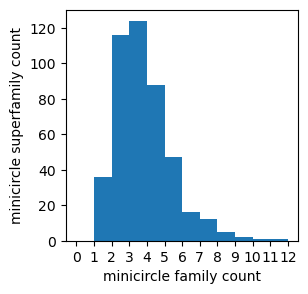

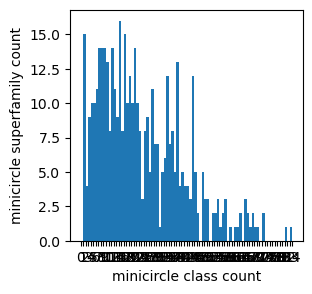

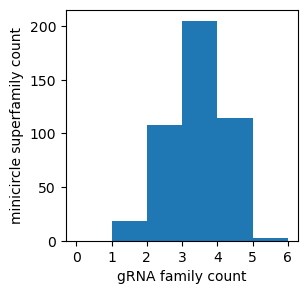

In [10]:
superfam1=make_superfamilies_by_famiy(mini_families)
superfam2=make_superfamilies_by_class(mini_cass,gRNA_dict)
superfam1=merge_superfamilies(superfam1,'family')
superfam2=merge_superfamilies(superfam2,'class')
gRNA_fam_per_superfamily(superfam1)

In [11]:
#isolate gRNA dict
def isolate_dicts(df,gRNA_dict,mini_cass,s):
    minis = [i for i in df.loc[s].dropna().index if 'Tb_mO' in i]
    #print(sorted(minis))
    grnatmp={k:v for k,v in gRNA_dict.items() if v['mO_name'] in minis}
    mini_casstmp={k:v for k,v in mini_cass.items() if k in minis}
    cass_dicttmp={k:v for k,v in cass_dict.items() if v['mO_name'] in minis}
    print(f"found {len(grnatmp)} gRNAs {len(mini_casstmp)} minicircles in {s} and {len(cass_dicttmp)} cassettes")
    return(grnatmp,mini_casstmp,cass_dicttmp,minis)
#
def base_line_seq_id_cass_diff_gf(mini_dict,gRNA_dict,cassdict,bslsize):
    records=[]
    cassettes=['I','II','III','IV','V']
    canonical=[k for k,v in cassdict.items() if v['type']=='canonical' ]
    count=0
    for pair in combinations(canonical,2):
        if count<=bslsize:
            k1,k2=pair[0],pair[1]
            m1,m2=cassdict[k1]['mO_name'],cassdict[k2]['mO_name']
            c1,c2=cassdict[k1]['cassette_label'],cassdict[k2]['cassette_label']
            g1,g2=mini_dict[f'{m1}'][c1],mini_dict[f'{m2}'][c2]
            gf1,gf2={gf.split('-')[0] for g in g1 for gf in gRNA_dict[g]['gRNA_family']},{gf.split('-')[0] for g in g2 for gf in gRNA_dict[g]['gRNA_family']}
            if len(gf1.intersection(gf2))==0:
                count+=1
                s1=cassdict[k1]['seq']
                s2=cassdict[k2]['seq']
                aligner = Align.PairwiseAligner()
                s1,s2 = aligner.align(s1,s2)[0]
                seqid=round(sum([1 for i,j in zip(s1,s2) if i==j])/len(s1)*100,2)
                records.append({'cassette1':k1,'cassette2':k2,'id':seqid} )
        else:
            break
    bsl=[d['id'] for d in records]
    return(bsl)

def get_box_plot_data(labels, bp):
    rows_list = []
    for i in range(len(labels)):
        dict1 = {}
        dict1['label'] = labels[i]
        dict1['lower_whisker'] = bp['whiskers'][i*2].get_ydata()[1]
        dict1['lower_quartile'] = bp['boxes'][i].get_ydata()[1]
        dict1['median'] = bp['medians'][i].get_ydata()[1]
        dict1['upper_quartile'] = bp['boxes'][i].get_ydata()[2]
        dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_ydata()[1]
        rows_list.append(dict1)
    return (pd.DataFrame(rows_list))

def get_bsl_levels(bsl):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3), sharey=False)
    boxprops = dict(linestyle='-', linewidth=4, color='b')
    medianprops = dict(linestyle='-', linewidth=4, color='r')
    labels=['baseline']
    bp=ax.boxplot([bsl],labels=labels,vert=True,boxprops=boxprops,medianprops=medianprops)
    levels=get_box_plot_data(labels, bp)
    return(levels)

def visual_minipairs(minipairs):
    shared=[iden for pair in minipairs for iden,hit in zip(pair['cassettes_id'].values(),[h for h in pair['hits'] if h!=0]) if hit==1]
    diff=[iden for pair in minipairs for iden,hit in zip(pair['cassettes_id'].values(),[h for h in pair['hits'] if h!=0]) if hit==2]
    a=ttest_ind(shared, diff)
    print(round(sum(shared)/len(shared),2),round(sum(diff)/len(diff),2),a.pvalue)
    data=[shared,diff]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3), sharey=False)
    boxprops = dict(linestyle='-', linewidth=4, color='b')
    medianprops = dict(linestyle='-', linewidth=4, color='r')
    labels=['same gRNA family','distinct gRNA family']
    bp=ax.boxplot(data,labels=labels,vert=True,boxprops=boxprops,medianprops=medianprops)
    ax.set_ylabel('SID (%)')
##
#identify pairs of mf with shared cassette families
def identify_pairs_similar_mf(mini_families,shared=1,diff=1):
    records,ts,total1=[],{},0
    for i,pair in enumerate(combinations(mini_families.keys(),2)):
        k1,k2=pair[0],pair[1]
        total1+=1
        #print(len(k1))
        #0=empty cassette, 1=homologous cassette, 2=diffeent cassette
        test=[0 if len(c1)==0 or len(c2)==0 else 1 if c1.issubset(c2) or c2.issubset(c1) else 2  # 0: empty/non-canonical, 1: shared, 2: distinct
              for c1,c2 in zip(mini_families[k1]['cassettes'].values(),mini_families[k2]['cassettes'].values())]
        ts[i]=test[:5]
        if ts[i].count(1)>=shared and ts[i].count(2)>=diff:
            records.append({k1:mini_families[k1],k2:mini_families[k2],'hits':ts[i]})
            #print(mini_families[k1]['cassettes'].values(),'\n',mini_families[k2]['cassettes'].values(),test)
    total,allpairs,counts=0,list(ts.keys()),[]
    df = pd.DataFrame(columns=[0,1,2,3,4], index=[0,1,2,3,4])
    for i in [0,1,2,3,4]:
        for j in [0,1,2,3,4]:
            a=[k for k,test in ts.items() if test.count(1)==i and test.count(2)==j]
            #print(i,j,len(a),round(len(a)/len(allpairs)*100,2))
            df.loc[i,j]=len(a)
            total+=len(a)
            counts.append(len(a))
    print(df)
    return(records,counts)
    
def identiy_pairs_similar_mini(mfpairs,cassdict,minis):
    minipairs=[]
    for record in mfpairs:
        k1,k2=list(record.keys())[0],list(record.keys())[1]
        mini1,mini2=record[k1]['population'],record[k2]['population']
        for m1 in [m for m in mini1 if m in minis]:
            try:
                cassettes1=[cassdict[f"{m1}_{c}"] 
                            for c,sets in record[k1]['cassettes'].items() if len(sets)!=0 and c!='Orphan']
            except:
                print(f'some cassettes not labelled in {m1}')
                continue
            for m2 in  [m for m in mini2 if m in minis]:
                try:
                    cassettes2=[cassdict[f"{m2}_{c}"] 
                            for c,sets in record[k2]['cassettes'].items() if len(sets)!=0 and c!='Orphan']
                except:
                    print(f'some cassettes not labelled in {m2}')
                    continue
                cassid={}
                for i,j in zip(cassettes1,cassettes2):
                    seq1=i['seq']
                    seq2=j['seq']
                    aligner = Align.PairwiseAligner()
                    seq1,seq2 = aligner.align(seq1,seq2)[0]
                    seqid=round(sum([1 for i,j in zip(seq1,seq2) if i==j])/len(seq1)*100,2)
                    cassid[i['cassette_label']]=seqid                  
                minipairs.append({'m1':m1,'m2':m2,'cassettes_id':cassid,'mf1':k1,'mf2':k2,'hits':record['hits']})
    return(minipairs)

def identiy_donor_cass(filtered2,mini_dict,mini_families,cassdict,cutoff=69.88):
    candidate_donors,test={},[]
    for i,record in enumerate(filtered2):
        candidate_donors[f"pair_{i+1}"]={}
        #c=[k for k,v in record['cassettes_id'].items() if v<cutoff][0]
        c=[k for k,h in zip(record['cassettes_id'],[h for h in record['hits'] if h!=0]) if h==2][0]
        shared=[v for v,h in zip(record['cassettes_id'].values(),[h for h in record['hits'] if h!=0]) if h==1]
        print(c)
        m1,m2=record['m1'],record['m2']
        seq1,seq2=cassdict[f'{m1}_{c}']['seq'],cassdict[f'{m2}_{c}']['seq']
        mf1,mf2=record['mf1'],record['mf2']
        gf1,gf2=set(mini_families[mf1]['cassettes'][c]),set(mini_families[mf2]['cassettes'][c])
        donor1=[(v['population'],cas) for cas in ['I','II','III','IV','V'] for k,v in mini_families.items() if len(set(v['cassettes'][cas]).intersection(gf1))!=0]
        donor2=[(v['population'],cas) for cas in ['I','II','III','IV','V'] for k,v in mini_families.items() if len(set(v['cassettes'][cas]).intersection(gf2))!=0]
        def filter_donors(seq,order,cass,donors,cassdict):
            tmp={'order':order}
            for record in donors:
                c=record[1]
                for donor in record[0]:
                    if f'{donor}_{c}' != cass:
                        donor_seq=cassdict[f'{donor}_{c}']['seq']
                        aligner = Align.PairwiseAligner()
                        seq1,seq2 = aligner.align(seq,donor_seq)[0]
                        seqid=round(sum([1 for i,j in zip(seq1,seq2) if i==j])/len(seq1)*100,2)
                        if seqid>min(shared):
                            tmp[f'{donor}_{c}']=seqid
            return(tmp)
        candidate_donors[f"pair_{i+1}"][f'{m1}_{c}']=filter_donors(seq1,1,f'{m1}_{c}',donor1,cassdict)
        candidate_donors[f"pair_{i+1}"][f'{m2}_{c}']=filter_donors(seq2,2,f'{m2}_{c}',donor2,cassdict)
        #test.append(filter_donors(seq1,1,f'{m1}_{c}',donor1,cassdict))
        #test.append(filter_donors(seq2,2,f'{m2}_{c}',donor2,cassdict))
        #print(gf2,donor1)
    return(candidate_donors)

def output_filtered(filtered, mini_families,outfile):
    outdict={i:{} for i,p in enumerate(filtered)}
    for i,v in enumerate(filtered):
        outdict[i]['m1'],outdict[i]['m2']=v['m1'],v['m2']
        for c,sid in v['cassettes_id'].items():
            #if mini_families[v['mf1']]['cassettes'][c]==mini_families[v['mf2']]['cassettes'][c]:
            #    outdict[i][c]=f"{','.join(mini_families[v['mf1']]['cassettes'][c])}: {sid}%"
            #else:
            #    outdict[i][c]=f"{','.join(mini_families[v['mf1']]['cassettes'][c])}/{','.join(mini_families[v['mf2']]['cassettes'][c])}: {sid}%"
            outdict[i][c]=sid
    df=pd.DataFrame.from_dict(outdict,orient='index')
    df.to_csv(outfile)
    return(outdict)


#isolate_gRNA_dict(combined,gRNA_dict,'TbgII_LIGO')
#isolate_gRNA_dict(combined,gRNA_dict,'Tbr_MHOM-ZM-82-TRPZ186')
Tb_mini_seq='/home/jovyan/Minicircle_gRNA_families/Recombination_Infiles/Tb_minicircles_0.95.noSitaBip.fa'
strain_seq=SeqIO.to_dict(SeqIO.parse(Tb_mini_seq,'fasta'))


In [12]:
def main(strain,strain_seq,bslsize=100):
    grnatmp,mini_casstmp,cass_dicttmp,minis=isolate_dicts(combined,gRNA_dict,mini_cass,strain)
    mini_to_fam_dict={m:k for k,v in mini_families.items() for m in v['population']}
    mfs=set([mini_to_fam_dict[m] for m in mini_casstmp])
    mfams={k:v for k,v in mini_families.items() if k in mfs}
    print(len(mfams))
    #mini_families=make_minicircle_family(mini_casstmp,grnatmp)
    for k,v in cass_dicttmp.items():
            cass_dicttmp[k]['seq']=strain_seq[f"{cass_dicttmp[k]['mO_name']}"].seq[v['forward_start']:v['reverse_end']] #add the cassette sequences
    bsl=base_line_seq_id_cass_diff_gf(mini_casstmp,grnatmp,cass_dicttmp,bslsize)
    levels=get_bsl_levels(bsl)
    print(levels)
    mfpairs,counts=identify_pairs_similar_mf(mfams,shared=2,diff=1)
    #print(sorted(cass_dicttmp.keys()))
    #mfpairs,counts=identify_pairs_similar_mf(superfam2,shared=2,diff=1)
    minipairs=identiy_pairs_similar_mini(mfpairs,cass_dicttmp,minis)
    print(f"{len(minipairs)} pairs of minicircles were compared")
    visual_minipairs(minipairs)
    cut=float(levels['upper_whisker'].iloc[0])
    print(cut)
    filtered1=[pair for pair in minipairs 
             if sum([1 if hit==1 and iden < cut else 0 for iden,hit in zip(pair['cassettes_id'].values(),[i for i in pair['hits'] if i!=0])])==0] #0 if none of the shared  <=cut
    filtered2=[pair for pair in filtered1 
             if sum([1 if hit==2 and iden >= cut else 0 for iden,hit in zip(pair['cassettes_id'].values(),[i for i in pair['hits'] if i!=0])])==0]#0 if none of the distinct >=cut
    if len(filtered2)>1:
        visual_minipairs(filtered2)
    print(f"{len(filtered2)} pairs strong support a recombination history")
    #donor=identiy_donor_cass(filtered2,mini_casstmp,mini_families,cass_dicttmp,cutoff=cut)
    #print(len(donor))
    #make an output for the filtered pairs
    outfile=f'/home/jovyan/Minicircle_gRNA_families/Work_files/Recombination/{strain}_recombination_pairs.csv'
    outdict=output_filtered(filtered2, mini_families,outfile)
    return(filtered2,mfpairs)



In [13]:
minis = [i for i in combined.loc['TbgII_LIGO'].dropna().index if 'Tb_mO' in i]

found 1361 gRNAs 543 minicircles in TbgII_LIGO and 1881 cassettes
354
      label  lower_whisker  lower_quartile  median  upper_quartile  \
0  baseline          58.66           62.86   64.33           65.68   

   upper_whisker  
0          69.82  
      0      1      2     3    4
0  7780  24379  22169  6651  378
1   286    451    197    22    0
2   101     32      2     0    0
3    29      4      0     0    0
4     0      0      0     0    0
83 pairs of minicircles were compared
68.15 64.99 6.177979033404072e-10
69.82
71.24 64.48 3.9411121265787914e-07
6 pairs strong support a recombination history


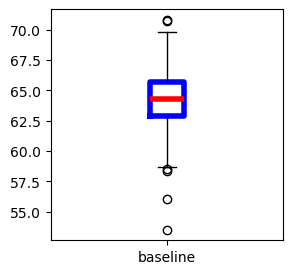

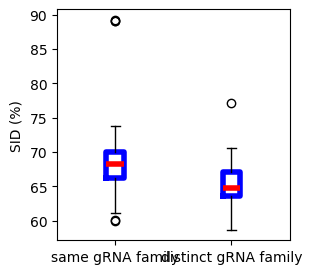

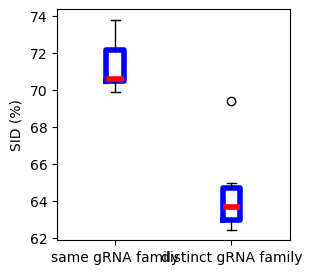

In [14]:
filtered2tbg2,mfpairs=main('TbgII_LIGO',strain_seq,bslsize=500)

found 963 gRNAs 379 minicircles in Tbr_MHOM-ZM-82-TRPZ186 and 1292 cassettes
289
      label  lower_whisker  lower_quartile  median  upper_quartile  \
0  baseline          59.78           64.25    65.9           67.25   

   upper_whisker  
0          71.51  
      0      1      2     3    4
0  3811  15158  15305  6293  244
1   184    315    178    10    0
2    61     33      0     0    0
3    24      0      0     0    0
4     0      0      0     0    0
48 pairs of minicircles were compared
68.41 65.24 7.40100299888573e-08
71.51
1 pairs strong support a recombination history


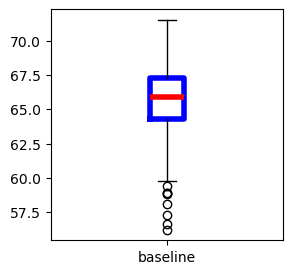

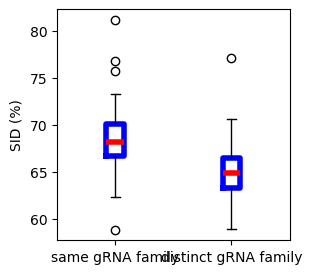

In [15]:
filtered2tbr,donortbr=main('Tbr_MHOM-ZM-82-TRPZ186',strain_seq,bslsize=500)

found 1632 gRNAs 660 minicircles in Tbb_MALC-BF-80-AB25 and 2246 cassettes
393
      label  lower_whisker  lower_quartile  median  upper_quartile  \
0  baseline          58.66           62.71    64.2           65.54   

   upper_whisker  
0          69.41  
      0      1      2      3    4
0  9198  28519  27113  10171  493
1   356    568    343     29    0
2   138     59      1      0    0
3    34      6      0      0    0
4     0      0      0      0    0
some cassettes not labelled in Tb_mO_1903
some cassettes not labelled in Tb_mO_1879
163 pairs of minicircles were compared
68.28 65.01 8.592096672033e-16
69.41
73.05 64.2 7.89950429363358e-14
20 pairs strong support a recombination history


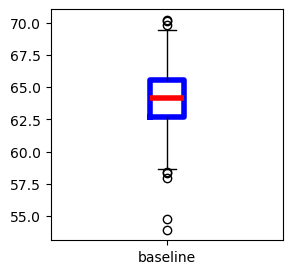

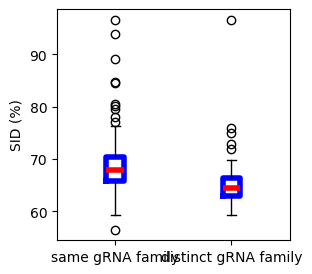

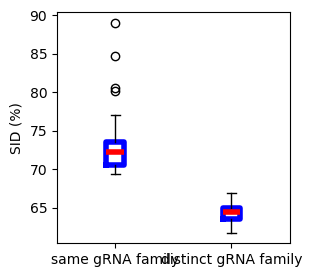

In [16]:
filtered2tbb,donortbb=main('Tbb_MALC-BF-80-AB25',strain_seq,bslsize=500)

In [17]:
#filtered2tbb

In [18]:
#number of canonical cassettes per minicircle
def count_number_of_cassettes(mini_families):
    counts=[len([cass for cass,gf in v['cassettes'].items() if len(gf)>0]) for k,v in mini_families.items()]
    df = pd.DataFrame({'counts':counts})
    a=df.value_counts()
    print(a,[round(i/len(counts)*100,1) for i in a])
def number_of_mf_per_isolate(combined,mini_families):
    df=combined[[m for m in combined.columns if 'Tb_mO' in m]]
    mini_to_fam_dict={m:k for k,v in mini_families.items() for m in v['population']}
    mfs_counts={}
    for s in df.index:
        mfs_counts[s]={k:0 for k in mini_families}
        minis=df.loc[s].dropna(how='all')
        #print(minis)
        for m in minis.index:
            if m in mini_to_fam_dict:#some minicircles do not have canonical gRNAs
                mfs_counts[s][mini_to_fam_dict[m]]+=df.loc[s,m]
    #drop all 0 columns so they will appear as nan later
        mfs_counts[s]={k:v for k,v in mfs_counts[s].items() if v!=0}
        mfs_counts[s]['minicircle family count']=len(mfs_counts[s])
    mfs_counts=pd.DataFrame.from_dict(mfs_counts,orient='index')
    #add info
    mfs_counts['taxon']=combined['taxon']
    return(mfs_counts)
count_number_of_cassettes(mini_families)
mfs_counts=number_of_mf_per_isolate(combined,mini_families)

counts
2         321
3         321
1         125
4         122
5           3
Name: count, dtype: int64 [36.0, 36.0, 14.0, 13.7, 0.3]


In [19]:
mfs_counts.to_csv('/home/jovyan//Tbeqev/Infiles/Tb_mf_counts.csv')

In [20]:
len(mini_families)

892

number of minicircle classes
T.b. gambiense type I 193
T.b. gambiense type II 1850
T.b. rhodesiense 1992
T.b. brucei 4890
T.b. gambiense type I 159
T.b. gambiense type II 565
T.b. rhodesiense 608
T.b. brucei 832


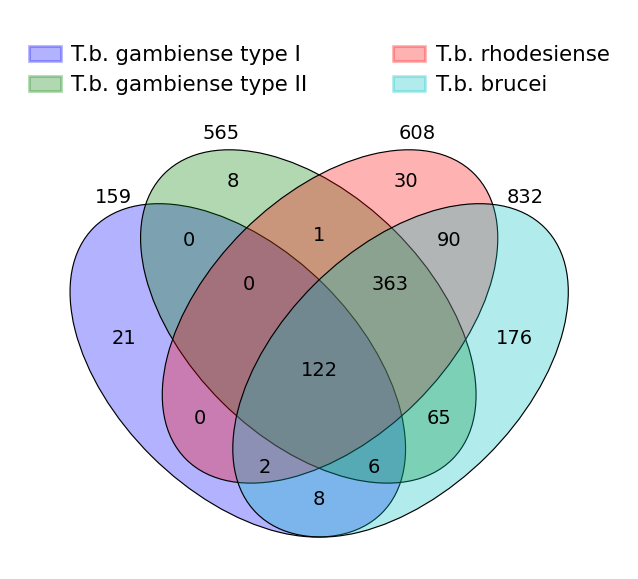

In [21]:
#number of minicircle families per subspecies
subspecies=[ 'T.b. gambiense type I', 'T.b. gambiense type II', 'T.b. rhodesiense','T.b. brucei']
def number_of_minicircle_classes(combined):
    print('number of minicircle classes')
    for sp in subspecies:
        df=combined[combined['taxon']==sp]
        df=df[[m for m in df.columns if 'Tb_mO' in m]]
        df = df.dropna(axis=1, how='all')
        print(sp,len(df.columns))

def number_of_minicircle_families(mfs_counts):
    sets={}
    for sp in subspecies:
        df=mfs_counts[mfs_counts['taxon']==sp]
        df=df[[m for m in df.columns if 'mf' in m]]
        df = df.dropna(axis=1, how='all')
        print(sp,len(df.columns))
        sets[sp]=set(df.columns)
    venny4py(sets=sets)
number_of_minicircle_classes(combined)
number_of_minicircle_families(mfs_counts)

In [22]:
def isolate_with_the_most_minicircle_families(mfs_counts,combined):
    sets={}
    for sp in subspecies:
        df=mfs_counts[mfs_counts['taxon']==sp]
        #df=df[[m for m in df.columns if 'mf' in m]]
        df = df.dropna(axis=1, how='all')
        idx=df['minicircle family count'].idxmax()
        print(f"{idx}: minicircle family count {df.loc[idx,'minicircle family count']} minicircle class count: {combined.loc[idx,'minicircle_classes']}")

isolate_with_the_most_minicircle_families(mfs_counts,combined)
#mfs_counts['minicircle family count']

TbgI_MHOM-CI-91-SIQUE1623: minicircle family count 132 minicircle class count: 135
TbgII_LIGO: minicircle family count 354 minicircle class count: 556
Tbr_MHOM-ZM-82-TRPZ186: minicircle family count 289 minicircle class count: 386
Tbb_MALC-BF-80-AB25: minicircle family count 393 minicircle class count: 676


In [23]:
combined[[c for c in combined.columns if 'Tb_mO' not in c]].loc[['TbgII_AnTat-25-1S']]
combined[[c for c in combined.columns if 'Tb_mO' not in c]].loc[['Tbb_MALC-BF-80-AB25']]
combined[[c for c in combined.columns if 'Tb_mO' not in c]].loc[['Tbb_MBOT-CI-78-TC348']]

,Maxicircle,network_size,strain,alias 1,alias 2,seq batch,seq platform,read length,taxon,Year of isolation,country,continent,location,host,TgsGP-qPCR,SRA-qPCR,minicircle_classes,Total MCN per network
renamed,,,,,,,,,,,,,,,,,,
Tbb_MBOT-CI-78-TC348,30,3496.58,NaN,NaN,NaN,BATCH3,BGI,150,T.b. brucei,na,CÃ´te d'Ivoire,West Africa,KOUDOUGOU-CARREFOUR,cattle,-1,-1,566,3466.58


In [24]:
def stats(d):
    mean=round(sum(d)/len(d),2)
    med=statistics.median(d)
    mod=statistics.mode(d)
    print(f"mean: {mean}, median: {med}, mode: {mod}, max: {max(d)}, min: {min(d)}")
def plot_from_df(df,feature):
    taxa=['T.b. rhodesiense','T.b. brucei','T.b. gambiense type II','T.b. gambiense type I']
    data=[df[df['taxon']==t][feature] for t in taxa]
    labels=taxa
    #statistics
    print('levene test for equal variances')
    grouped = df.groupby(['taxon'])
    size_by_group = [g[feature].values for _, g in grouped]
    print(grouped[feature].std().round(1))
    statistic, pvalue = levene(*size_by_group, center='mean')
    #print(f'upper critical value of F_c=F_(0.05, {k-1}, {N-k}) = {f.ppf(1-0.05, k-1, N-k):.2f}')
    print(f'W = {statistic:.2f}, p = {pvalue:.2g}\n')
    for t in taxa:
        n=len(df[df['taxon']==t])
        mean=sum(df[df['taxon']==t][feature])/n
        st=round(statistics.stdev(df[df['taxon']==t][feature]),2)
        print(f"{t}: mean={round(mean,2)} st={st} sample size={n}")
        stats(df[df['taxon']==t][feature])
    pairs=combinations(taxa, 2)
    for p in pairs:
        query=df[df['taxon']==p[0]][feature]
        subject=df[df['taxon']==p[1]][feature]
        a=ttest_ind(subject, query)
        if a.pvalue<1:
            print(f"{p[0]} vs {p[1]}",a.pvalue)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4), sharey=False)
    boxprops = dict(linestyle='-', linewidth=4, color='b')
    medianprops = dict(linestyle='-', linewidth=4, color='r')
    ax.boxplot(data,labels=labels,vert=False,boxprops=boxprops,medianprops=medianprops)
    ax.tick_params(labelsize=20)
    ax.set_yticklabels(labels,style='italic')
    ax.set_xlabel(f'{feature}',fontsize=20)
    plt.show()
    

levene test for equal variances
taxon
T.b. brucei               65.7
T.b. gambiense type I     12.7
T.b. gambiense type II    67.3
T.b. rhodesiense          52.3
Name: minicircle family count, dtype: float64
W = 40.17, p = 9.6e-21

T.b. rhodesiense: mean=223.7 st=52.3 sample size=23
mean: 223.7, median: 236, mode: 268, max: 289, min: 90
T.b. brucei: mean=242.07 st=65.69 sample size=76
mean: 242.07, median: 243.0, mode: 199, max: 393, min: 69
T.b. gambiense type II: mean=219.57 st=67.34 sample size=14
mean: 219.57, median: 209.5, mode: 213, max: 354, min: 126
T.b. gambiense type I: mean=108.67 st=12.69 sample size=111
mean: 108.67, median: 111, mode: 118, max: 132, min: 51
T.b. rhodesiense vs T.b. brucei 0.22274542488514512
T.b. rhodesiense vs T.b. gambiense type II 0.8360206264698394
T.b. rhodesiense vs T.b. gambiense type I 3.29872285151052e-43
T.b. brucei vs T.b. gambiense type II 0.24395904769890714
T.b. brucei vs T.b. gambiense type I 1.7998636545000813e-50
T.b. gambiense type II v

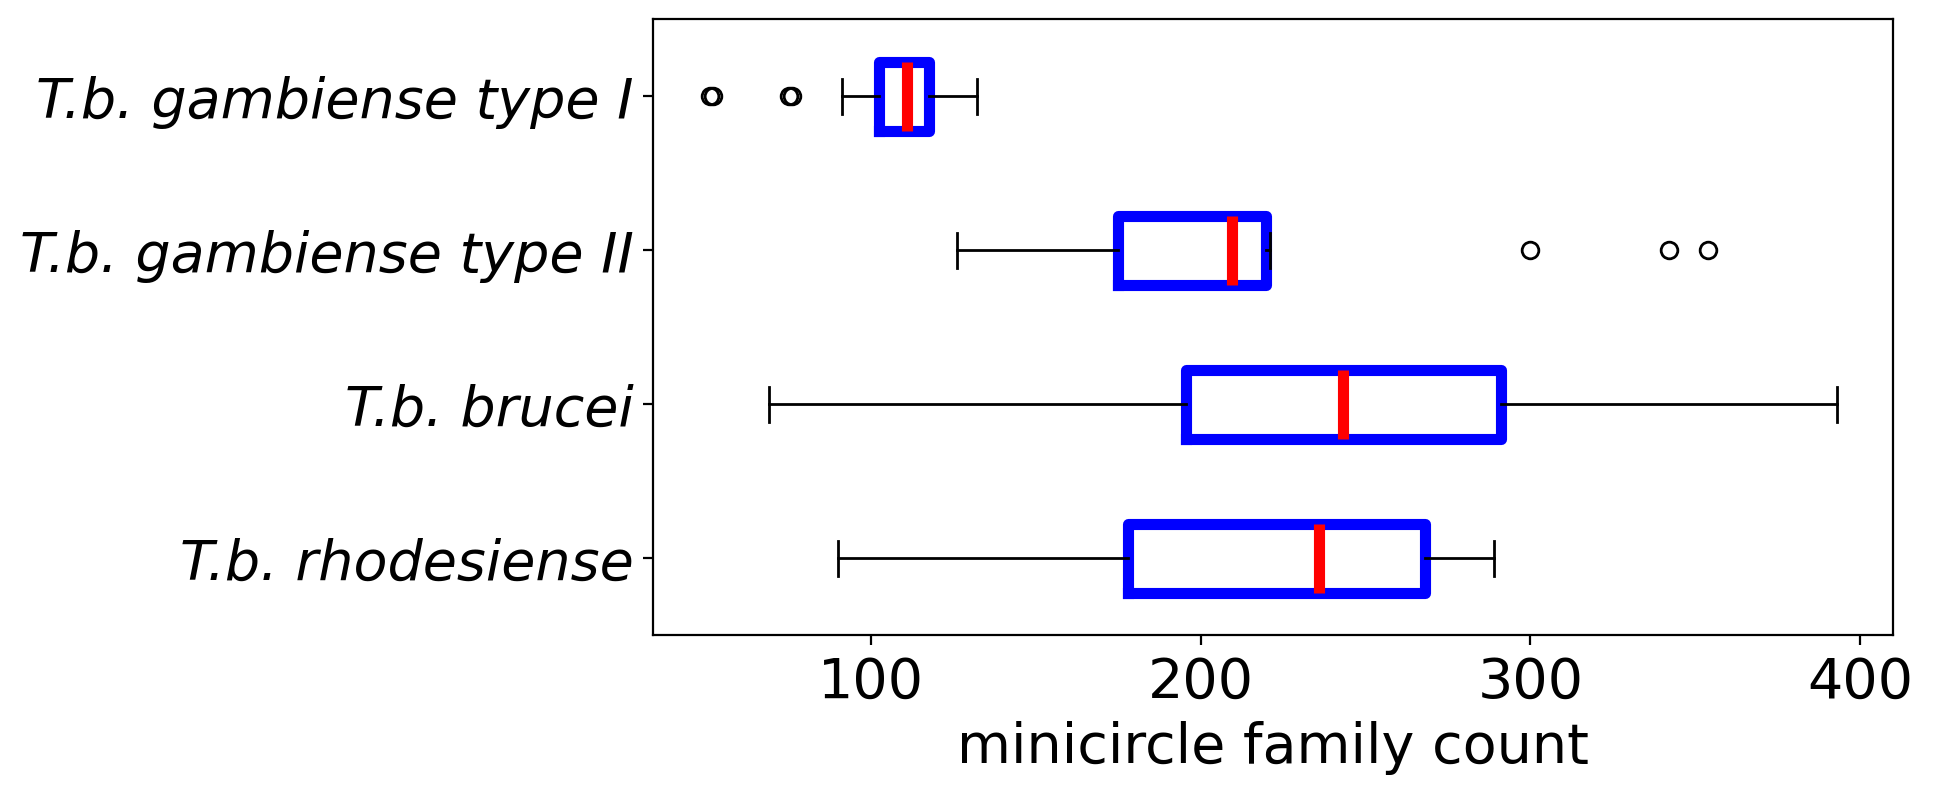

In [25]:
plot_from_df(mfs_counts,'minicircle family count')

T.b. gambiense type I 153
T.b. gambiense type II 368
T.b. rhodesiense 376
T.b. brucei 435


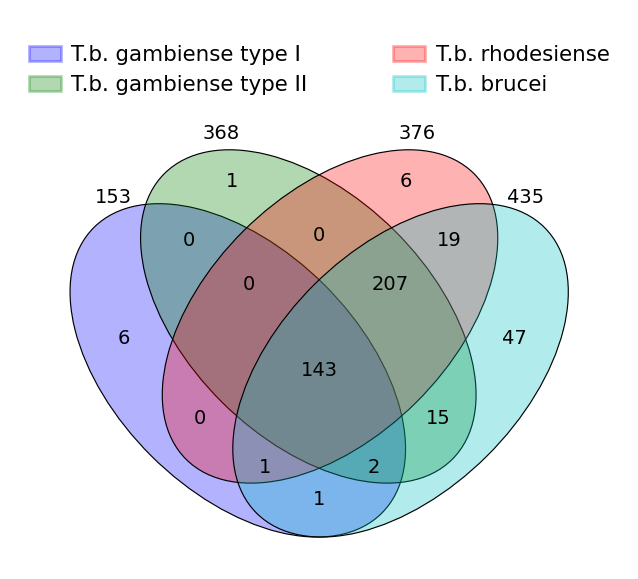

In [26]:
#superfamily counts
smf_counts=number_of_mf_per_isolate(combined,superfam2)
number_of_minicircle_families(smf_counts)

levene test for equal variances
taxon
T.b. brucei               48.0
T.b. gambiense type I     12.4
T.b. gambiense type II    45.8
T.b. rhodesiense          39.2
Name: minicircle superfamily count, dtype: float64
W = 30.63, p = 1.4e-16

T.b. rhodesiense: mean=195.61 st=39.22 sample size=23
mean: 195.61, median: 205, mode: 230, max: 240, min: 82
T.b. brucei: mean=209.63 st=48.04 sample size=76
mean: 209.63, median: 214.0, mode: 224, max: 310, min: 66
T.b. gambiense type II: mean=191.36 st=45.83 sample size=14
mean: 191.36, median: 188.5, mode: 193, max: 281, min: 123
T.b. gambiense type I: mean=107.57 st=12.41 sample size=111
mean: 107.57, median: 110, mode: 104, max: 130, min: 51
T.b. rhodesiense vs T.b. brucei 0.2051058304800563
T.b. rhodesiense vs T.b. gambiense type II 0.7658767335758235
T.b. rhodesiense vs T.b. gambiense type I 6.805832811989906e-41
T.b. brucei vs T.b. gambiense type II 0.1913664290760422
T.b. brucei vs T.b. gambiense type I 6.744307905592123e-52
T.b. gambiense typ

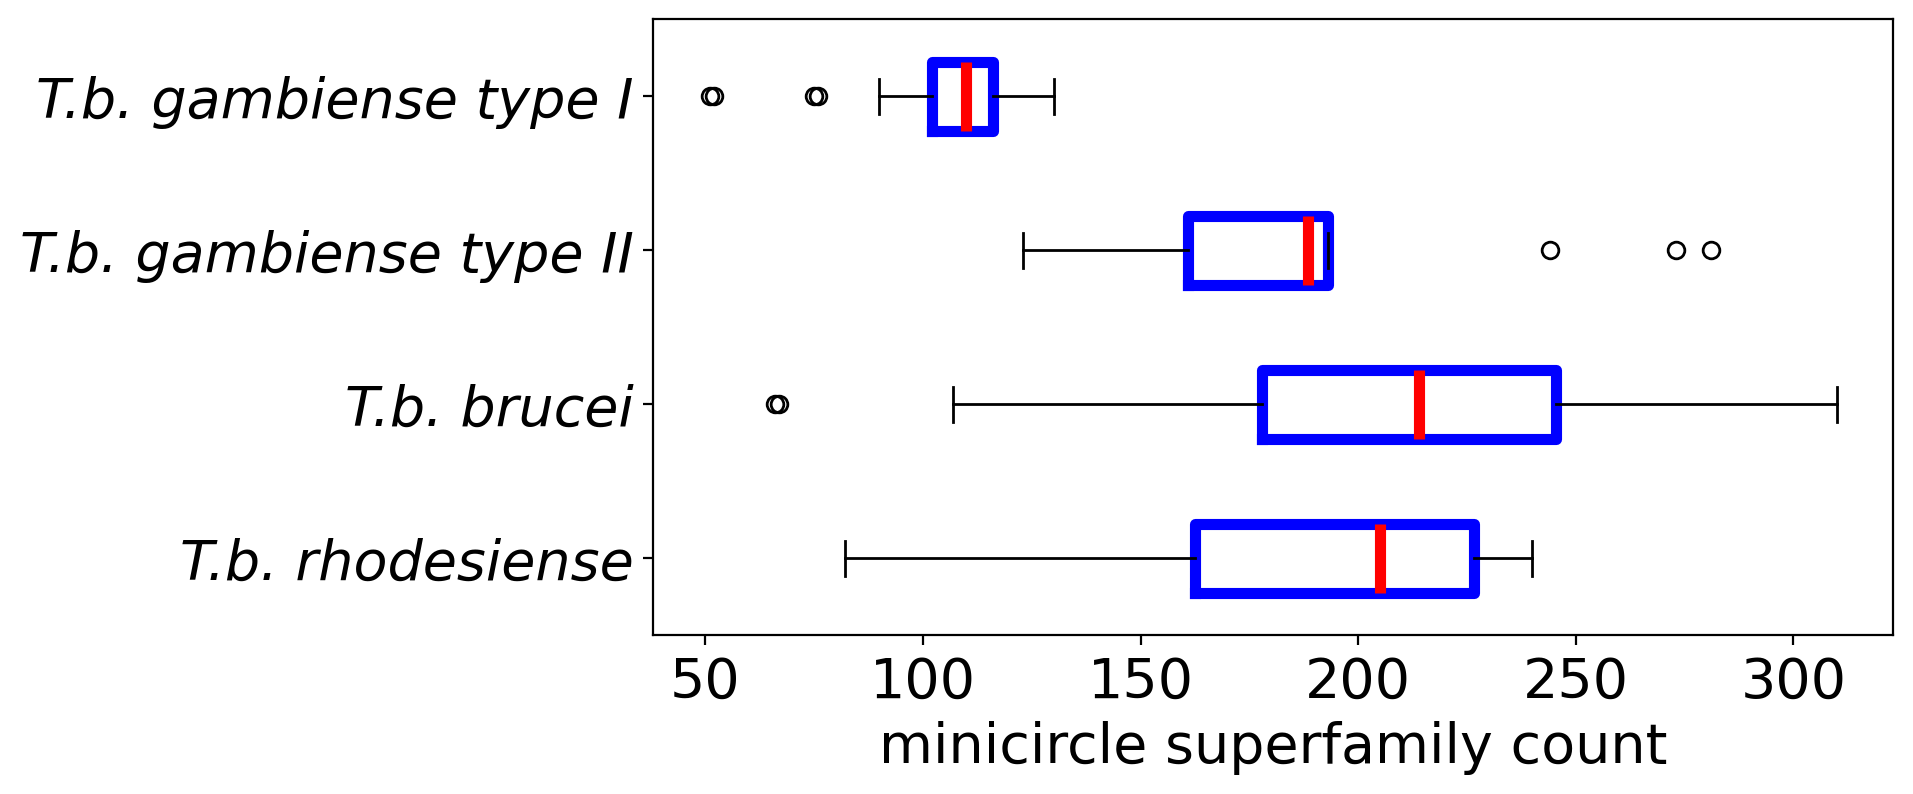

In [27]:
smf_counts['minicircle superfamily count']=smf_counts['minicircle family count']
plot_from_df(smf_counts,'minicircle superfamily count')

T.b. gambiense type I 193
T.b. gambiense type II 1850
T.b. rhodesiense 1992
T.b. brucei 4890


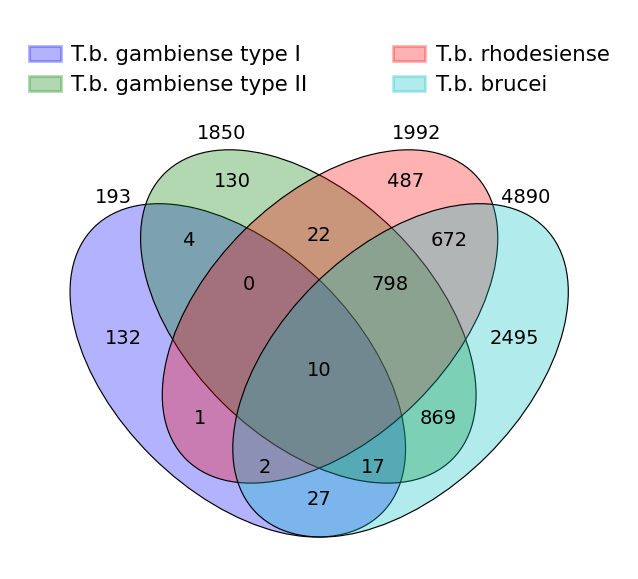

In [28]:
def number_of_minicircle_classes(mfs_counts):
    sets={}
    for sp in subspecies:
        df=mfs_counts[mfs_counts['taxon']==sp]
        df=df[[m for m in df.columns if 'Tb_mO' in m]]
        df = df.dropna(axis=1, how='all')
        print(sp,len(df.columns))
        sets[sp]=set(df.columns)
    venny4py(sets=sets)
number_of_minicircle_classes(combined)

In [43]:
#output morphological sequence
def add_related_mf2(mfs_counts,mini_families,superfam1,superfam2): #use mini fam dataframe directly
    df=mfs_counts[[m for m in mfs_counts.columns if 'mf' in m]]
    mini_to_fam_dict={m:k for k,v in mini_families.items() for m in v['population']}
    mf_to_smf={m:k for k,v in superfam1.items() for m in v['population']}
    mini_to_smf={m:k for k,v in superfam2.items() for m in v['population']}
    morph_seq={}
    for s in df.index:
        morph_seq[s]={k:'-' for k in mini_families}#default: not found
        minis=df.loc[s].dropna()
        #print(minis)
        for selfmf in minis.index:
            smf=mf_to_smf[selfmf]
            for mf in superfam1[smf]['population']:
                #check if the mf is a subset of the one represented by the minicircle
                test=[0 if c2.issubset(c1) else 1 for c1,c2 in zip(mini_families[selfmf]['cassettes'].values(),mini_families[mf]['cassettes'].values())]
                if sum(test)==0 and morph_seq[s][mf]=='-': #if subset on all cassettes
                    morph_seq[s][mf]='R' #for all in related: add as R
            #add all mfs that are exactly the same
            morph_seq[s][selfmf]='p' #treat the exact
    morph_seq=pd.DataFrame.from_dict(morph_seq,orient='index')
    #add info
    #mfs_counts['taxon']=combined['taxon']
    return(morph_seq)

def add_related_mf1(mfs_counts,mini_families,superfam1,superfam2): #use all superfam, loose
    df=mfs_counts[[m for m in mfs_counts.columns if 'mf' in m]]
    mini_to_fam_dict={m:k for k,v in mini_families.items() for m in v['population']}
    mf_to_smf={m:k for k,v in superfam1.items() for m in v['population']}
    mini_to_smf={m:k for k,v in superfam2.items() for m in v['population']}
    morph_seq={}
    for s in df.index:
        morph_seq[s]={k:'-' for k in mini_families}#default: not found
        minis=df.loc[s].dropna()
        #print(minis)
        for selfmf in minis.index:
            smf=mf_to_smf[selfmf]
            for mf in superfam1[smf]['population']:
                if morph_seq[s][mf]=='-':
                    morph_seq[s][mf]='R' #for all in related: add as R
            #add all mfs that are exactly the same
            morph_seq[s][selfmf]='p' #treat the exact
    morph_seq=pd.DataFrame.from_dict(morph_seq,orient='index')
    #add info
    #mfs_counts['taxon']=combined['taxon']
    return(morph_seq)
#output morphological sequence
def add_related_mf_binary2(mfs_counts,mini_families,superfam1,superfam2): #use mini fam dataframe directly
    df=mfs_counts[[m for m in mfs_counts.columns if 'mf' in m]]
    mini_to_fam_dict={m:k for k,v in mini_families.items() for m in v['population']}
    mf_to_smf={m:k for k,v in superfam1.items() for m in v['population']}
    mini_to_smf={m:k for k,v in superfam2.items() for m in v['population']}
    morph_seq={}
    for s in df.index:
        morph_seq[s]={k:'0' for k in mini_families}#default: not found
        minis=df.loc[s].dropna()
        #print(minis)
        for selfmf in minis.index:
            smf=mf_to_smf[selfmf]
            for mf in superfam1[smf]['population']:
                #check if the mf is a subset of the one represented by the minicircle
                test=[0 if c2.issubset(c1) else 1 for c1,c2 in zip(mini_families[selfmf]['cassettes'].values(),mini_families[mf]['cassettes'].values())]
                if sum(test)==0: #if subset on all cassettes
                    morph_seq[s][mf]='1' #for all in related: add as R
            #add all mfs that are exactly the same
            morph_seq[s][selfmf]='1' #treat the exact
    morph_seq=pd.DataFrame.from_dict(morph_seq,orient='index')
    #add info
    #mfs_counts['taxon']=combined['taxon']
    return(morph_seq)

def add_related_mf_binary1(mfs_counts,mini_families,superfam1,superfam2): #use all superfam, loose
    df=mfs_counts[[m for m in mfs_counts.columns if 'mf' in m]]
    mini_to_fam_dict={m:k for k,v in mini_families.items() for m in v['population']}
    mf_to_smf={m:k for k,v in superfam1.items() for m in v['population']}
    mini_to_smf={m:k for k,v in superfam2.items() for m in v['population']}
    morph_seq={}
    for s in df.index:
        morph_seq[s]={k:'0' for k in mini_families}#default: not found
        minis=df.loc[s].dropna()
        #print(minis)
        for selfmf in minis.index:
            smf=mf_to_smf[selfmf]
            for mf in superfam1[smf]['population']:
                morph_seq[s][mf]='1' #for all in related: add as R
            #add all mfs that are exactly the same
            morph_seq[s][selfmf]='1' #treat the exact
    morph_seq=pd.DataFrame.from_dict(morph_seq,orient='index')
    #add info
    #mfs_counts['taxon']=combined['taxon']
    return(morph_seq)
def make_morph_sequence(morphseq,combined,outfile): #only need to include metadf, so combined is actually better, as the name has changed accordingly already
    surfix={'Central Africa':'CA','East Africa':'EA','na':'na','North Africa':'NA','Southern Africa':'SA','West Africa':'WA'}
    records=[]
    for s in morphseq.index:
        country=combined.loc[s,'country'].replace(' ','_')
        if country=='Democratic_Republic_of_the_Congo':
            country='DRC'
        elif 'Ivoire' in country:
            country='Ivory_Coast'
        records.append(SeqRecord(Seq(''.join(morphseq.loc[s])),
            id=f"{s}_{surfix[combined.loc[s,'continent']]}_{country.replace(' ','_')}_{combined.loc[s,'Year of isolation']}",
            description=s,name=s))
    #add continent as surfix for coloring
    #records=[SeqRecord(Seq(''.join(morphseq.loc[s])),
    #        id=f"{s}_{surfix[combined.loc[s,'continent']]}_{combined.loc[s,'country'].replace(' ','_')}_{combined.loc[s,'Year of isolation']}",
    #        description=s,name=s) for s in morphseq.index]
    #records=[SeqRecord(Seq(''.join(morphseq.loc[s])),
    #        id=f"{s}_{surfix.get(combined.loc[s,'continent'],'na')}_{combined.loc[s,'Year of isolation']}",
    #        description=s,name=s) for s in morphseq.index]
    SeqIO.write(records,outfile,'fasta')
    return(records)

#binary version does not work better than P-R version, abort
outdir='/home/jovyan/Minicircle_gRNA_families/Tb_phylogeny/'
morphseq1=add_related_mf_binary1(mfs_counts,mini_families,superfam1,superfam2)
morphseq2=add_related_mf_binary2(mfs_counts,mini_families,superfam1,superfam2)
records1=make_morph_sequence(morphseq1,combined,f"{outdir}/morphseq_binary_loose.fasta")
records2=make_morph_sequence(morphseq2,combined,f"{outdir}/morphseq_binary_strict.fasta")

In [44]:
outdir='/home/jovyan/Minicircle_gRNA_families/Tb_phylogeny/'
morphseq1=add_related_mf1(mfs_counts,mini_families,superfam1,superfam2)
morphseq2=add_related_mf2(mfs_counts,mini_families,superfam1,superfam2)
records1=make_morph_sequence(morphseq1,combined,f"{outdir}/morphseq_loose.fasta")
records2=make_morph_sequence(morphseq2,combined,f"{outdir}/morphseq_strict.fasta")

#add OVI isolates# 
#was an experiment. do not add
ovi_mfs={'mf30': 1, 'mf11': 1, 'mf126': 1, 'mf143': 1, 'mf205': 1, 'mf220': 1, 'mf204': 1, 'mf221': 1, 'mf160': 1, 'mf229': 1, 'mf277': 1, 'mf162': 1, 'mf145': 1, 'mf185': 1, 'mf170': 1, 'mf379': 1, 'mf306': 1, 'mf255': 1, 'mf149': 1, 'mf272': 1, 'mf429': 1, 'mf169': 1, 'mf173': 1, 'mf492': 1, 'mf653': 1, 'mf470': 1, 'mf536': 1, 'mf629': 1, 'mf532': 1, 'mf686': 1, 'mf527': 1, 'mf649': 1, 'mf710': 1, 'mf688': 1, 'mf660': 1, 'mf708': 1, 'mf486': 1, 'mf803': 1, 'mf872': 1, 'mf887': 1}
#add OVI to mfs_counts
for k,v in ovi_mfs.items():
    mfs_counts.loc['type_OVI',k]=v
#make morph seq with the type OVI mini fam included
morphseq1=add_related_mf1(mfs_counts,mini_families,superfam1,superfam2)
morphseq2=add_related_mf2(mfs_counts,mini_families,superfam1,superfam2)
records1=make_morph_sequence(morphseq1,combined,f"{outdir}/morphseq_with_OVI_loose.fasta")
records2=make_morph_sequence(morphseq2,combined,f"{outdir}/morphseq_with_OVI_strict.fasta")

In [119]:
combined.loc['type_OVI'] = [0 for i in range(1, len(combined.columns) + 1)]
combined.loc['type_OVI','continent']

0

In [36]:
#test
morphseq1.loc[['TbgI_104AT', 'TbgI_104BT']]

,mf1,mf2,mf3,mf4,mf5,mf6,mf7,mf8,mf9,mf10,mf11,mf12,mf13,mf14,mf15,mf16,mf17,mf18,mf19,mf20,mf21,mf22,mf23,mf24,mf25,mf26,mf27,mf28,mf29,mf30,mf31,mf32,mf33,mf34,mf35,mf36,mf37,mf38,mf39,mf40,mf41,mf42,mf43,mf44,mf45,mf46,mf47,mf48,mf49,mf50,mf51,mf52,mf53,mf54,mf55,mf56,mf57,mf58,mf59,mf60,mf61,mf62,mf63,mf64,mf65,mf66,mf67,mf68,mf69,mf70,mf71,mf72,mf73,mf74,mf75,mf76,mf77,mf78,mf79,mf80,mf81,mf82,mf83,mf84,mf85,mf86,mf87,mf88,mf89,mf90,mf91,mf92,mf93,mf94,mf95,mf96,mf97,mf98,mf99,mf100,mf101,mf102,mf103,mf104,mf105,mf106,mf107,mf108,mf109,mf110,mf111,mf112,mf113,mf114,mf115,mf116,mf117,mf118,mf119,mf120,mf121,mf122,mf123,mf124,mf125,mf126,mf127,mf128,mf129,mf130,mf131,mf132,mf133,mf134,mf135,mf136,mf137,mf138,mf139,mf140,mf141,mf142,mf143,mf144,mf145,mf146,mf147,mf148,mf149,mf150,mf151,mf152,mf153,mf154,mf155,mf156,mf157,mf158,mf159,mf160,mf161,mf162,mf163,mf164,mf165,mf166,mf167,mf168,mf169,mf170,mf171,mf172,mf173,mf174,mf175,mf176,mf177,mf178,mf179,mf180,mf181,mf182,mf183,mf184,mf185,mf186,mf187,mf188,mf189,mf190,mf191,mf192,mf193,mf194,mf195,mf196,mf197,mf198,mf199,mf200,mf201,mf202,mf203,mf204,mf205,mf206,mf207,mf208,mf209,mf210,mf211,mf212,mf213,mf214,mf215,mf216,mf217,mf218,mf219,mf220,mf221,mf222,mf223,mf224,mf225,mf226,mf227,mf228,mf229,mf230,mf231,mf232,mf233,mf234,mf235,mf236,mf237,mf238,mf239,mf240,mf241,mf242,mf243,mf244,mf245,mf246,mf247,mf248,mf249,mf250,mf251,mf252,mf253,mf254,mf255,mf256,mf257,mf258,mf259,mf260,mf261,mf262,mf263,mf264,mf265,mf266,mf267,mf268,mf269,mf270,mf271,mf272,mf273,mf274,mf275,mf276,mf277,mf278,mf279,mf280,mf281,mf282,mf283,mf284,mf285,mf286,mf287,mf288,mf289,mf290,mf291,mf292,mf293,mf294,mf295,mf296,mf297,mf298,mf299,mf300,mf301,mf302,mf303,mf304,mf305,mf306,mf307,mf308,mf309,mf310,mf311,mf312,mf313,mf314,mf315,mf316,mf317,mf318,mf319,mf320,mf321,mf322,mf323,mf324,mf325,mf326,mf327,mf328,mf329,mf330,mf331,mf332,mf333,mf334,mf335,mf336,mf337,mf338,mf339,mf340,mf341,mf342,mf343,mf344,mf345,mf346,mf347,mf348,mf349,mf350,mf351,mf352,mf353,mf354,mf355,mf356,mf357,mf358,mf359,mf360,mf361,mf362,mf363,mf364,mf365,mf366,mf367,mf368,mf369,mf370,mf371,mf372,mf373,mf374,mf375,mf376,mf377,mf378,mf379,mf380,mf381,mf382,mf383,mf384,mf385,mf386,mf387,mf388,mf389,mf390,mf391,mf392,mf393,mf394,mf395,mf396,mf397,mf398,mf399,mf400,mf401,mf402,mf403,mf404,mf405,mf406,mf407,mf408,mf409,mf410,mf411,mf412,mf413,mf414,mf415,mf416,mf417,mf418,mf419,mf420,mf421,mf422,mf423,mf424,mf425,mf426,mf427,mf428,mf429,mf430,mf431,mf432,mf433,mf434,mf435,mf436,mf437,mf438,mf439,mf440,mf441,mf442,mf443,mf444,mf445,mf446,mf447,mf448,mf449,mf450,mf451,mf452,mf453,mf454,mf455,mf456,mf457,mf458,mf459,mf460,mf461,mf462,mf463,mf464,mf465,mf466,mf467,mf468,mf469,mf470,mf471,mf472,mf473,mf474,mf475,mf476,mf477,mf478,mf479,mf480,mf481,mf482,mf483,mf484,mf485,mf486,mf487,mf488,mf489,mf490,mf491,mf492,mf493,mf494,mf495,mf496,mf497,mf498,mf499,mf500,mf501,mf502,mf503,mf504,mf505,mf506,mf507,mf508,mf509,mf510,mf511,mf512,mf513,mf514,mf515,mf516,mf517,mf518,mf519,mf520,mf521,mf522,mf523,mf524,mf525,mf526,mf527,mf528,mf529,mf530,mf531,mf532,mf533,mf534,mf535,mf536,mf537,mf538,mf539,mf540,mf541,mf542,mf543,mf544,mf545,mf546,mf547,mf548,mf549,mf550,mf551,mf552,mf553,mf554,mf555,mf556,mf557,mf558,mf559,mf560,mf561,mf562,mf563,mf564,mf565,mf566,mf567,mf568,mf569,mf570,mf571,mf572,mf573,mf574,mf575,mf576,mf577,mf578,mf579,mf580,mf581,mf582,mf583,mf584,mf585,mf586,mf587,mf588,mf589,mf590,mf591,mf592,mf593,mf594,mf595,mf596,mf597,mf598,mf599,mf600,mf601,mf602,mf603,mf604,mf605,mf606,mf607,mf608,mf609,mf610,mf611,mf612,mf613,mf614,mf615,mf616,mf617,mf618,mf619,mf620,mf621,mf622,mf623,mf624,mf625,mf626,mf627,mf628,mf629,mf630,mf631,mf632,mf633,mf634,mf635,mf636,mf637,mf638,mf639,mf640,mf641,mf642,mf643,mf644,mf645,mf646,mf647,mf648,mf649,mf650,mf651,mf652,mf653,mf654,mf655,mf656,mf657,mf658,mf659,mf660,mf661,mf662,mf663,mf664,mf665,mf666,mf667,mf668,mf669,mf670,mf671,mf672,mf673,mf674,mf675,mf676,mf677,mf678,mf679,mf680,mf681,mf682,mf683,mf684,mf6

In [37]:
#test
morphseq2.loc[['TbgI_104AT', 'TbgI_104BT']]

,mf1,mf2,mf3,mf4,mf5,mf6,mf7,mf8,mf9,mf10,mf11,mf12,mf13,mf14,mf15,mf16,mf17,mf18,mf19,mf20,mf21,mf22,mf23,mf24,mf25,mf26,mf27,mf28,mf29,mf30,mf31,mf32,mf33,mf34,mf35,mf36,mf37,mf38,mf39,mf40,mf41,mf42,mf43,mf44,mf45,mf46,mf47,mf48,mf49,mf50,mf51,mf52,mf53,mf54,mf55,mf56,mf57,mf58,mf59,mf60,mf61,mf62,mf63,mf64,mf65,mf66,mf67,mf68,mf69,mf70,mf71,mf72,mf73,mf74,mf75,mf76,mf77,mf78,mf79,mf80,mf81,mf82,mf83,mf84,mf85,mf86,mf87,mf88,mf89,mf90,mf91,mf92,mf93,mf94,mf95,mf96,mf97,mf98,mf99,mf100,mf101,mf102,mf103,mf104,mf105,mf106,mf107,mf108,mf109,mf110,mf111,mf112,mf113,mf114,mf115,mf116,mf117,mf118,mf119,mf120,mf121,mf122,mf123,mf124,mf125,mf126,mf127,mf128,mf129,mf130,mf131,mf132,mf133,mf134,mf135,mf136,mf137,mf138,mf139,mf140,mf141,mf142,mf143,mf144,mf145,mf146,mf147,mf148,mf149,mf150,mf151,mf152,mf153,mf154,mf155,mf156,mf157,mf158,mf159,mf160,mf161,mf162,mf163,mf164,mf165,mf166,mf167,mf168,mf169,mf170,mf171,mf172,mf173,mf174,mf175,mf176,mf177,mf178,mf179,mf180,mf181,mf182,mf183,mf184,mf185,mf186,mf187,mf188,mf189,mf190,mf191,mf192,mf193,mf194,mf195,mf196,mf197,mf198,mf199,mf200,mf201,mf202,mf203,mf204,mf205,mf206,mf207,mf208,mf209,mf210,mf211,mf212,mf213,mf214,mf215,mf216,mf217,mf218,mf219,mf220,mf221,mf222,mf223,mf224,mf225,mf226,mf227,mf228,mf229,mf230,mf231,mf232,mf233,mf234,mf235,mf236,mf237,mf238,mf239,mf240,mf241,mf242,mf243,mf244,mf245,mf246,mf247,mf248,mf249,mf250,mf251,mf252,mf253,mf254,mf255,mf256,mf257,mf258,mf259,mf260,mf261,mf262,mf263,mf264,mf265,mf266,mf267,mf268,mf269,mf270,mf271,mf272,mf273,mf274,mf275,mf276,mf277,mf278,mf279,mf280,mf281,mf282,mf283,mf284,mf285,mf286,mf287,mf288,mf289,mf290,mf291,mf292,mf293,mf294,mf295,mf296,mf297,mf298,mf299,mf300,mf301,mf302,mf303,mf304,mf305,mf306,mf307,mf308,mf309,mf310,mf311,mf312,mf313,mf314,mf315,mf316,mf317,mf318,mf319,mf320,mf321,mf322,mf323,mf324,mf325,mf326,mf327,mf328,mf329,mf330,mf331,mf332,mf333,mf334,mf335,mf336,mf337,mf338,mf339,mf340,mf341,mf342,mf343,mf344,mf345,mf346,mf347,mf348,mf349,mf350,mf351,mf352,mf353,mf354,mf355,mf356,mf357,mf358,mf359,mf360,mf361,mf362,mf363,mf364,mf365,mf366,mf367,mf368,mf369,mf370,mf371,mf372,mf373,mf374,mf375,mf376,mf377,mf378,mf379,mf380,mf381,mf382,mf383,mf384,mf385,mf386,mf387,mf388,mf389,mf390,mf391,mf392,mf393,mf394,mf395,mf396,mf397,mf398,mf399,mf400,mf401,mf402,mf403,mf404,mf405,mf406,mf407,mf408,mf409,mf410,mf411,mf412,mf413,mf414,mf415,mf416,mf417,mf418,mf419,mf420,mf421,mf422,mf423,mf424,mf425,mf426,mf427,mf428,mf429,mf430,mf431,mf432,mf433,mf434,mf435,mf436,mf437,mf438,mf439,mf440,mf441,mf442,mf443,mf444,mf445,mf446,mf447,mf448,mf449,mf450,mf451,mf452,mf453,mf454,mf455,mf456,mf457,mf458,mf459,mf460,mf461,mf462,mf463,mf464,mf465,mf466,mf467,mf468,mf469,mf470,mf471,mf472,mf473,mf474,mf475,mf476,mf477,mf478,mf479,mf480,mf481,mf482,mf483,mf484,mf485,mf486,mf487,mf488,mf489,mf490,mf491,mf492,mf493,mf494,mf495,mf496,mf497,mf498,mf499,mf500,mf501,mf502,mf503,mf504,mf505,mf506,mf507,mf508,mf509,mf510,mf511,mf512,mf513,mf514,mf515,mf516,mf517,mf518,mf519,mf520,mf521,mf522,mf523,mf524,mf525,mf526,mf527,mf528,mf529,mf530,mf531,mf532,mf533,mf534,mf535,mf536,mf537,mf538,mf539,mf540,mf541,mf542,mf543,mf544,mf545,mf546,mf547,mf548,mf549,mf550,mf551,mf552,mf553,mf554,mf555,mf556,mf557,mf558,mf559,mf560,mf561,mf562,mf563,mf564,mf565,mf566,mf567,mf568,mf569,mf570,mf571,mf572,mf573,mf574,mf575,mf576,mf577,mf578,mf579,mf580,mf581,mf582,mf583,mf584,mf585,mf586,mf587,mf588,mf589,mf590,mf591,mf592,mf593,mf594,mf595,mf596,mf597,mf598,mf599,mf600,mf601,mf602,mf603,mf604,mf605,mf606,mf607,mf608,mf609,mf610,mf611,mf612,mf613,mf614,mf615,mf616,mf617,mf618,mf619,mf620,mf621,mf622,mf623,mf624,mf625,mf626,mf627,mf628,mf629,mf630,mf631,mf632,mf633,mf634,mf635,mf636,mf637,mf638,mf639,mf640,mf641,mf642,mf643,mf644,mf645,mf646,mf647,mf648,mf649,mf650,mf651,mf652,mf653,mf654,mf655,mf656,mf657,mf658,mf659,mf660,mf661,mf662,mf663,mf664,mf665,mf666,mf667,mf668,mf669,mf670,mf671,mf672,mf673,mf674,mf675,mf676,mf677,mf678,mf679,mf680,mf681,mf682,mf683,mf684,mf6

In [ ]:
#compare the gRNAs from teh same family but on different cassettes

def extract_gRNA_seq(grnas,gRNA_dict,strain_seq):
    seqdict= {g:strain_seq[gRNA_dict[g]['mO_name']].seq[int(gRNA_dict[g]['circle_start']):int(gRNA_dict[g]['circle_end'])] for g in grnas if gRNA_dict[g]['mO_name'] in strain_seq}
    seqid_dict={}
    for pair in combinations(seqdict.keys(),2):
        seq1=seqdict[pair[0]]
        seq2=seqdict[pair[1]]
        aligner = Align.PairwiseAligner()
        seq1,seq2 = aligner.align(seq1,seq2)[0]
        seqid=round(sum([1 for i,j in zip(seq1,seq2) if i==j])/len(seq1)*100,2)
        if gRNA_dict[pair[0]]['cassette_label']==gRNA_dict[pair[1]]['cassette_label']:
            diff='same'
        else:
            diff='different'
        seqid_dict[pair]={'sid':seqid,'diff':diff}
    return(seqid_dict)

def calculate_SID(multicas):
    all_dict={}
    for gf,v in multicas.items():
        SIDs=extract_gRNA_seq(v['gRNA'],gRNA_dict,strain_seq)
        all_dict.update(SIDs)
    return(all_dict)

def pickle_out(out,outfile):
    with gzip.open(outfile, 'wb') as f:
        pickle.dump(out, f)
    f.close()
    print(len(out))

def pickle_load(file,prefix):
    with gzip.open(file, 'rb') as f:
        print(f'file {file} loaded')
        out=pickle.load(f)
    return out

def compare_multiple_vs_single(multicas_seqids,onecas_seqids):
    multi=[v['sid'] for v in multicas_seqids.values()]
    one=[v['sid'] for v in onecas_seqids.values()]
    a=ttest_ind(multi, one)
        #if a.pvalue<0.05:
    print('pvalue',round(a.pvalue,4),f"multiple mean: {round(sum(multi)/len(multi),2)} vs single mean {round(sum(one)/len(one),2)}")
    data=[multi,one]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), sharey=False)
    boxprops = dict(linestyle='-', linewidth=4, color='b')
    medianprops = dict(linestyle='-', linewidth=4, color='r')
    labels=['multiple cassettes','single cassette']
    bp=ax.boxplot(data,labels=labels,vert=True,boxprops=boxprops,medianprops=medianprops)
    ax.set_ylabel('SID (%)')

def compare_same_vs_diff_in_multi(multicas_seqids):
    multi=[v['sid'] for v in multicas_seqids.values() if v['diff']=='different']
    one=[v['sid'] for v in multicas_seqids.values() if v['diff']=='same']
    a=ttest_ind(multi, one)
        #if a.pvalue<0.05:
    print('pvalue',round(a.pvalue,4),f"multiple mean: {round(sum(multi)/len(multi),2)} vs single mean {round(sum(one)/len(one),2)}")
    data=[multi,one]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), sharey=False)
    boxprops = dict(linestyle='-', linewidth=4, color='b')
    medianprops = dict(linestyle='-', linewidth=4, color='r')
    labels=['different cassettes','same cassette']
    bp=ax.boxplot(data,labels=labels,vert=True,boxprops=boxprops,medianprops=medianprops)
    ax.set_ylabel('SID (%)')

In [ ]:
multicas={k:v for k,v in gfam.items() if len([k for k,v in v['cassettes'].items() if v!=0 and k!='Orphan'])>1}
onecas={k:v for k,v in gfam.items() if len([k for k,v in v['cassettes'].items() if v!=0 and k!='Orphan'])==1}
print(f"found {len(multicas)} gRNA families on multiple cassettes and {len(onecas)} gRNAs families on a single cassette")

In [ ]:
#multicas_seqids=calculate_SID(multicas)

In [ ]:
#onecas_seqids=calculate_SID(onecas)

In [ ]:
#pickle_out(multicas_seqids,'/home/jovyan/Minicircle_gRNA_families/Work_files/Recombination/multiple_cass_sid.pickle')
#pickle_out(onecas_seqids,'/home/jovyan/Minicircle_gRNA_families/Work_files/Recombination/single_cass_sid.pickle')

In [ ]:
compare_multiple_vs_single(multicas_seqids,onecas_seqids)

In [ ]:
compare_same_vs_diff_in_multi(multicas_seqids)